# Working directly with psydat files

The recommended way to analyse your data in Python is to use the provided pandas DataFrame of data and statistics.

However, if you need to you can access the raw data from which these DataFrames are constructed directly as shown in the examples below.

In [1]:
from psychopy.misc import fromFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon, LinearRing
from shapely.ops import polygonize, unary_union
from shapely.validation import make_valid
# from matplotlib.patches import Polygon

### Import

A psydat file can be imported using the psychopy `fromFile` function: 

In [2]:
psydata = fromFile("example.psydat")

### Contents

This returns a Python object that contains all of the trial conditions and results as attributes.
These attributes can be listed using the Python `vars` function:

In [3]:
for var in vars(psydata):
    print(var, end=" | ")

name | autoLog | trialList | nReps | trialWeights | nTotal | nRemaining | method | thisRepN | thisTrialN | thisN | thisIndex | thisTrial | finished | extraInfo | seed | data | sequenceIndices | originPath | origin | _exp | 

### Conditions

The trial conditions are in `trialList`, each element in this list is a dict of trial conditions that defines a trial:

In [4]:
psydata.trialList

[{'weight': 2,
  'num_targets': 8,
  'target_order': 'clockwise',
  'target_indices': '0 1 2 3 4 5 6 7',
  'target_duration': 5.0,
  'inter_target_duration': 0.0,
  'target_distance': 0.4,
  'target_size': 0.04,
  'central_target_size': 0.02,
  'show_inactive_targets': True,
  'play_sound': True,
  'show_cursor': True,
  'cursor_size': 0.02,
  'show_cursor_path': True,
  'automove_cursor_to_center': False,
  'cursor_rotation_degrees': 0.0,
  'post_trial_delay': 0.0,
  'post_trial_display_results': False,
  'post_block_delay': 0.0,
  'post_block_display_results': True},
 {'weight': 2,
  'num_targets': 6,
  'target_order': 'random',
  'target_indices': '1 5 0 3 4 2',
  'target_duration': 5.0,
  'inter_target_duration': 0.0,
  'target_distance': 0.4,
  'target_size': 0.04,
  'central_target_size': 0.02,
  'show_inactive_targets': True,
  'play_sound': True,
  'show_cursor': True,
  'cursor_size': 0.02,
  'show_cursor_path': True,
  'automove_cursor_to_center': True,
  'cursor_rotation_deg

This can be more easily viewed if converted to a pandas DataFrame:

In [5]:
pd.DataFrame(psydata.trialList)

,weight,num_targets,target_order,target_indices,target_duration,inter_target_duration,target_distance,target_size,central_target_size,show_inactive_targets,play_sound,show_cursor,cursor_size,show_cursor_path,automove_cursor_to_center,cursor_rotation_degrees,post_trial_delay,post_trial_display_results,post_block_delay,post_block_display_results
0,2,8,clockwise,0 1 2 3 4 5 6 7,5.0,0.0,0.4,0.04,0.02,True,True,True,0.02,True,False,0.0,0.0,False,0.0,True
1,2,6,random,1 5 0 3 4 2,5.0,0.0,0.4,0.04,0.02,True,True,True,0.02,True,True,0.0,0.0,False,0.0,True


The `weight` of a trial is how many times it should be repeated.
This information is also stored in the `trialWeights` list, so for example `trialList[i]` will be repeated `trialWeights[i]` times

In [6]:
psydata.trialWeights

[2, 2]

A block consists of doing a trial with each condition in `trialList` `weight` times, where `weight` can be a different number for each trial, so the total number of trials done in a block is then given by

$$
nTrials = \sum_i^{nConditions} weight[i]
$$

This block is then repeared `nReps` times:

In [7]:
psydata.nReps

1

The total number of trials `nTotal` is then given by

$$
nTotal = nReps \times \left( \sum_i^{nConditions} weight[i] \right)
$$

In [8]:
psydata.nTotal

4

The condition used for a given trial `iTrial` and repetition number `iRep` is given by `sequenceIndices[iTrial][iRep]`, which gives the index of the conditions used in the `trialList` list:

In [9]:
psydata.sequenceIndices

array([[0],
       [0],
       [1],
       [1]])

The `method` specifies the order in which the trials were done:

- sequential
  - the same order as `trialList`
- random
  - order of trials shuffled within each block
- fullRandom
  - order of trials fully shuffled

In [10]:
psydata.method

'sequential'

### Results

The results of the trials are in `data` which contains a dict of numpy arrays of recorded data:

In [11]:
for key, value in psydata.data.items():
    print(key, value.shape)

ran (4, 1)
order (4, 1)
target_indices (4, 1)
target_pos (4, 1)
to_target_timestamps (4, 1)
to_target_mouse_positions (4, 1)
to_target_success (4, 1)
to_center_timestamps (4, 1)
to_center_mouse_positions (4, 1)
to_center_success (4, 1)


---------------------------------------------
area of Trial 0, Rep 0 [Condition 0]
blue, area: 0.011475
green, area: 0.017600
red, area: 0.016286
cyan, area: 0.011152
magenta, area: 0.012368
yellow, area: 0.036783
black, area: 0.007126
orange, area: 0.006413
---------------------------------------------
area of Trial 1, Rep 0 [Condition 0]
blue, area: 0.010713
green, area: 0.003865
red, area: 0.002857
cyan, area: 0.008542
magenta, area: 0.005670
yellow, area: 0.012619
black, area: 0.005373
orange, area: 0.010836


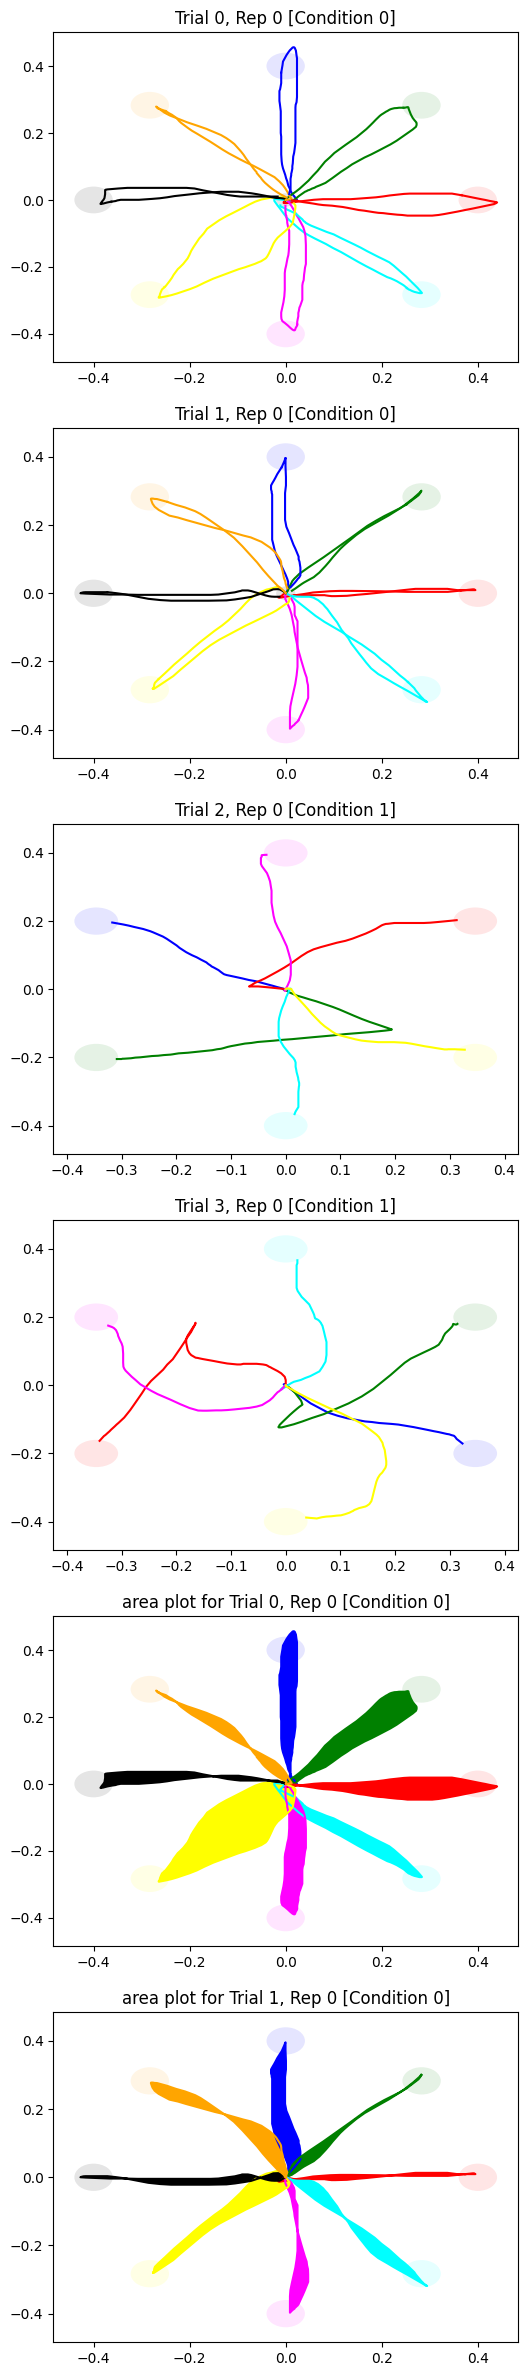

In [12]:
colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "orange"]
nTrials, nReps = psydata.sequenceIndices.shape
def get_axs_row():
    row = 0
    for condition in range(len(psydata.trialList)):
        if not psydata.trialList[condition]["automove_cursor_to_center"]:
            row += 2*psydata.trialWeights[condition]
        else:
            row += psydata.trialWeights[condition]
    return row

fig, axs = plt.subplots(get_axs_row(), nReps, figsize=(6, 6 * (nTrials+1) * nReps))
axs = np.reshape(
    axs, (get_axs_row(), nReps)
)  # ensure axs is a 2d-array even if nTrials or nReps is 1
for trial in range(nTrials):
    for rep in range(nReps):
        loc = (trial, rep)
        condition = psydata.sequenceIndices[loc]
        target_radius = psydata.trialList[condition]["target_size"]
        central_target_radius = psydata.trialList[condition]["central_target_size"]
        ax = axs[loc]
        ax.set_title(f"Trial {trial}, Rep {rep} [Condition {condition}]")
        for positions, target_pos, color in zip(
            psydata.data["to_target_mouse_positions"][loc],
            psydata.data["target_pos"][loc],
            colors,
        ):
            ax.plot(positions[:, 0], positions[:, 1], color=color)
            ax.add_patch(
                plt.Circle(
                    target_pos,
                    target_radius,
                    edgecolor="none",
                    facecolor=color,
                    alpha=0.1,
                )
            )

        # if condition "automove_cursor_to_center" is deselected, plot the line to center, fill the enclosed area and output the area
        if not psydata.trialList[condition]["automove_cursor_to_center"]:
            loc_area = (trial+nTrials, rep)
            ax_area = axs[loc_area]
            ax_area.set_title(f"area plot for Trial {trial}, Rep {rep} [Condition {condition}]")
            print("---------------------------------------------")
            print("area of Trial %d, Rep %d [Condition %s]" %(trial, rep, condition))
            for to_target_mouse_positions, to_center_mouse_positions, target_pos, color in zip(
                psydata.data["to_target_mouse_positions"][loc],
                psydata.data["to_center_mouse_positions"][loc],
                psydata.data["target_pos"][loc],
                colors,
            ):
                ax.plot(to_center_mouse_positions[:, 0], to_center_mouse_positions[:, 1], color=color)
                coords = np.concatenate((to_target_mouse_positions, to_center_mouse_positions))
                polygon = Polygon(coords)
                lr_coords = np.concatenate((coords[:], to_target_mouse_positions[0:1]))
                lr = LineString(lr_coords)
                validation = lr.is_valid
                multi_LineString = unary_union(lr)
                area = 0
                for pg in polygonize(multi_LineString):
                    area += pg.area
                    ax_area.plot(*pg.exterior.xy, color=color)
                    ax_area.fill(*pg.exterior.xy, facecolor=color)
                ax_area.add_patch(
                    plt.Circle(
                        target_pos,
                        target_radius,
                        edgecolor="none",
                        facecolor=color,
                        alpha=0.1,
                    )
                )
                print("%s, area: %f" %(color, area))

            ax.add_patch(
                plt.Circle(
                    [0, 0],
                    central_target_radius,
                    edgecolor="none",
                    facecolor="black",
                    alpha=0.1,
                )
            )

plt.show()

Each of these is a `nTrials` x `nReps` 2d array, where each element of this array contains the results from the corresponding trial for this variable (which might itself be a single value, e.g. `target_pos`, or an array of values, e.g. `timestamps`)

Which set of conditions was used is given by the `sequenceIndices` entry in the same location

### Plot of results for each trial

For example, a scatter plot of the mouse positions for each trial, labelled by the condition, trial number and repetition number:

### Plot of all trials combined for each condition

Here we instead make one plot for each set of conditions in `trialList`, and super-impose all of the corresponding results:

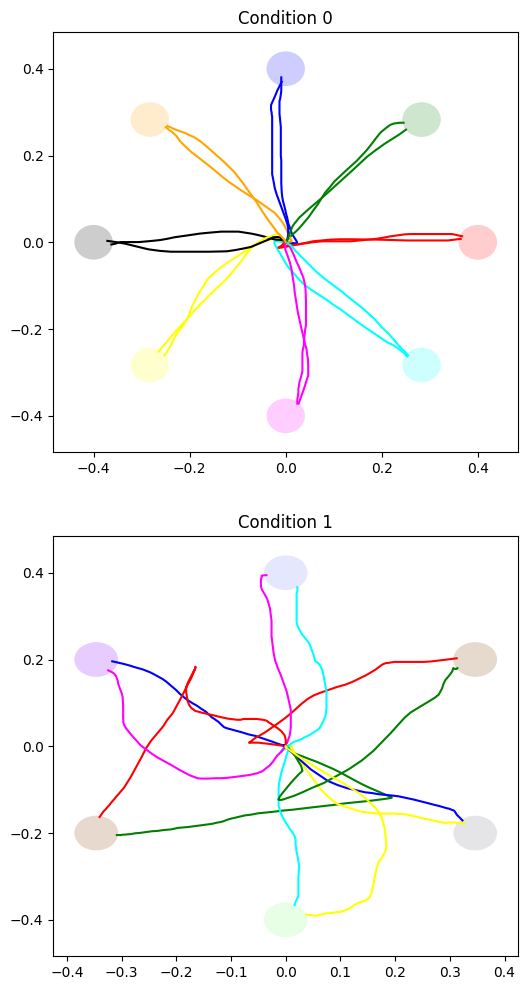

In [13]:
nConditions = len(psydata.trialList)
nTrials, nReps = psydata.sequenceIndices.shape
fig, axs = plt.subplots(nConditions, 1, figsize=(6, 6 * nConditions))
axs = np.reshape(axs, (nConditions))  # ensure axs is a 1d-array
for trial in range(nTrials):
    for rep in range(nReps):
        loc = (trial, rep)
        condition = psydata.sequenceIndices[loc]
        target_radius = psydata.trialList[condition]["target_size"]
        ax = axs[condition]
        ax.set_title(f"Condition {condition}")
        for positions, target_pos, color in zip(
            psydata.data["to_target_mouse_positions"][loc],
            psydata.data["target_pos"][loc],
            colors,
        ):
            ax.plot(positions[:, 0], positions[:, 1], color=color)
            ax.add_patch(
                plt.Circle(
                    target_pos,
                    target_radius,
                    edgecolor="none",
                    facecolor=color,
                    alpha=0.1,
                )
            )
plt.show()

### Plot of mouse movements vs time

A plot of `x`, `y`, and `distance from target` versus time for a single move to/from a target

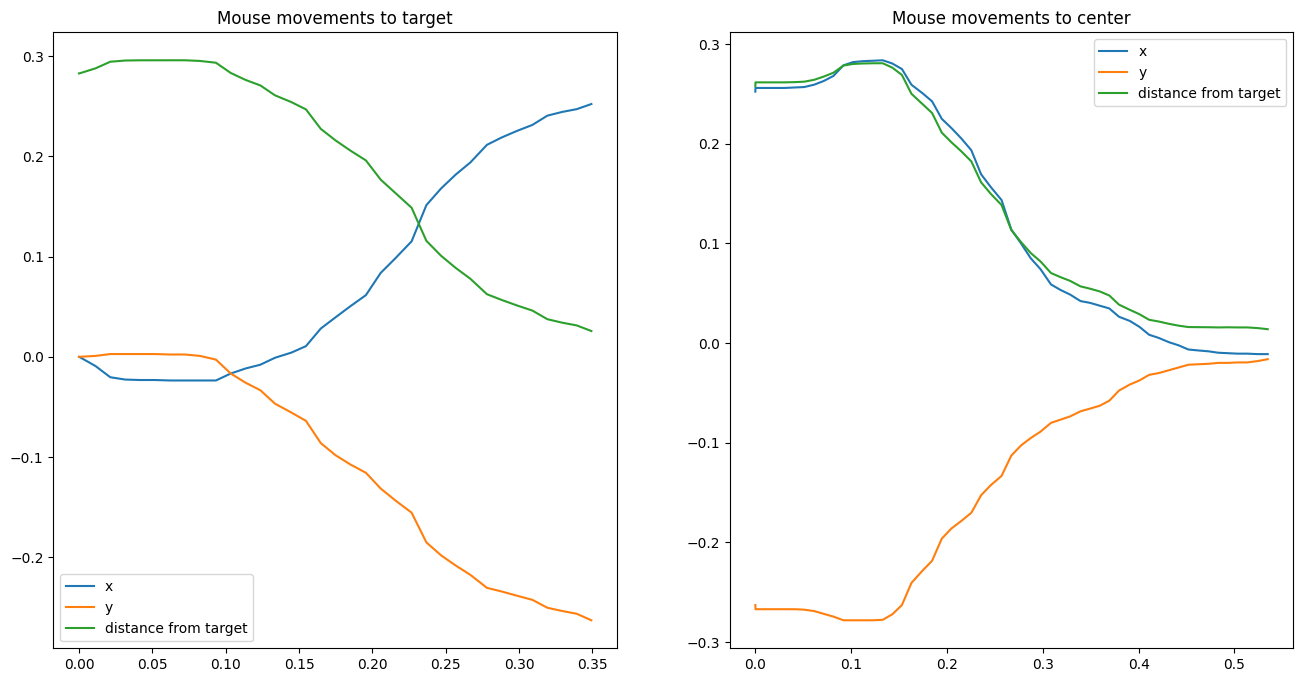

In [14]:
def dist(xys, xy0):
    return np.sqrt(np.mean(np.power(xys - xy0, 2), axis=1))


fig, axs = plt.subplots(1, 2, figsize=(16, 8))

trial = 0
rep = 0
i_target = 3
loc = (trial, rep)
condition = psydata.sequenceIndices[loc]
target_radius = psydata.trialList[condition]["target_size"]
central_target_radius = psydata.trialList[condition]["central_target_size"]
for dest, ax in zip(["target", "center"], axs):
    positions = psydata.data[f"to_{dest}_mouse_positions"][loc][i_target]
    if dest == "target":
        target = psydata.data["target_pos"][loc][i_target]
    else:
        target = [0, 0]
    times = psydata.data[f"to_{dest}_timestamps"][loc][i_target]
    ax.set_title(f"Mouse movements to {dest}")
    ax.plot(times, positions[:, 0], label="x")
    ax.plot(times, positions[:, 1], label="y")
    ax.plot(times, dist(positions, target), label="distance from target")
    ax.legend()
plt.show()
